In [1]:
import numpy as np
import pandas as pd

import cv2
from PIL import Image, ImageEnhance

import matplotlib.pyplot as plt
plt.style.use("dark_background")
import seaborn as sn

import os , shutil
from shutil import copyfile

from tqdm import tqdm
from pprint import pprint
import  gc

import albumentations as A
import io

import tensorflow as tf

rs = 42
from collections import Counter

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
def display_images(List = None, Labels = None, title = None,size = 2,cmap = 'jet',grid=None , scaling =['unit','minmax'][0]):
    try:
        if(List!=None):
            n = len(List)
            
            if(grid==None):
                grid = (1,n)
                
            fig = plt.figure(figsize = (size * grid[1], size*grid[0]))
            for i in range(n):
                plt.subplot(grid[0],grid[1],i+1)

                img  = List[i]
                img = np.array(img,dtype = np.float32)
                
                if(np.max(img)>1):
                    if(scaling == 'unit'):
                        # print('unit rescaling image')
                        img = img/255
                    else:
                        # print('min max rescaling image')
                        img = (img - img.min())/(img.max() - img.min())
                plt.imshow(img ,cmap = cmap)
                plt.axis('off')
                if(Labels != None):
                    plt.title(Labels[i],color = 'cyan')
            if(title):
                if(Labels):
                    fig.suptitle(title,fontsize = 15,y = 1.03)
                else:
                    fig.suptitle(title,fontsize = 15)
#                 plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print('Error :',e)
        

In [3]:
configuration = {
    'classes' : ['disgust','fear','neutral','happy','contempt','anger','sad','surprise'],
    'shape' : (96,96,3),
    'activation' : 'relu',
    'n_class':8,
    'n_epoch':50,
    'lr': 0.01,
    'batch_size':32,
}

## Getting The Data

In [4]:
os.environ['KAGGLE_USERNAME'] = 'prajwalsharma123'
os.environ['KAGGLE_KEY']='6719f9750ed948ff6d82400eab62fe8c'

In [5]:
!kaggle datasets download -d noamsegal/affectnet-training-data

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Dataset URL: https://www.kaggle.com/datasets/noamsegal/affectnet-training-data
License(s): Attribution-NonCommercial-ShareAlike 3.0 IGO (CC BY-NC-SA 3.0 IGO)
 99%|████████████████████████████████████████▍| 310M/314M [00:01<00:00, 333MB/s]
100%|█████████████████████████████████████████| 314M/314M [00:01<00:00, 322MB/s]


In [6]:
import zipfile
def Unzip_To_Folder(zip_path, dest_path ,remove_zip_path = True,remove_dest_path = True):     
    if(remove_dest_path):
        try:
            shutil.rmtree(dest_path)
        except Exception as e:
            print(e)
            os.makedirs(dest_path)

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_file:
            zip_file.extractall(dest_path)
        if(remove_zip_path):
            os.remove(zip_path) # remove zip file
        print('Extraction successfully executed')
    except Exception as e:
        print(e)

In [7]:
zip_path = 'affectnet-training-data.zip'
data_path = 'datasets/HumanFaces/'
Unzip_To_Folder(zip_path,data_path,True,True)

Extraction successfully executed


In [8]:
Labels = pd.read_csv('datasets/HumanFaces/labels.csv')
Labels.sample(5)

Unnamed: 0                        pth    label    relFCs
25526       25526  surprise/image0017495.jpg    anger  0.762148
13712       13712        happy/ffhq_3306.png    happy  0.781828
13932       13932        happy/ffhq_3504.png    happy  0.811796
5281         5281  contempt/image0041024.jpg  neutral  0.728915
11781       11781        happy/ffhq_1569.png    happy  0.825004

In [9]:
classes = configuration['classes']
new_data_path = 'datasets/HumanFaces/Images/'
try :
    shutil.rmtree(new_data_path)
except:
    pass
os.makedirs(new_data_path)
    
image_paths , image_labels1 ,image_labels2 = [],[],[]
for img_path , img_label in tqdm(Labels[['pth','label']].values):
    
    old_img_path = data_path + img_path
    new_img_path = new_data_path + '_'.join(img_path.split('/')) 
    shutil.copy(old_img_path,new_img_path)
    
    label1 = classes.index(img_label)
    label2 = classes.index(img_path.split('/')[0])
    
    image_labels1.append(label1)
    image_labels2.append(label2)
    image_paths.append(new_img_path)

100%|██████████| 28175/28175 [00:03<00:00, 8847.30it/s]


In [10]:
for class_ in tqdm(classes):
    shutil.rmtree(data_path + class_)

100%|██████████| 8/8 [00:00<00:00, 11.22it/s]


In [11]:
Data = pd.DataFrame({'paths':image_paths,'labels1':image_labels1,"labels2":image_labels2})
Data.sample(5)

paths  labels1  labels2
10295   datasets/HumanFaces/Images/fear_image0037760.jpg        7        1
6752   datasets/HumanFaces/Images/disgust_image003567...        7        0
24791    datasets/HumanFaces/Images/surprise_ffhq_77.png        7        7
20859    datasets/HumanFaces/Images/neutral_ffhq_702.png        2        2
26871  datasets/HumanFaces/Images/surprise_image00306...        7        7

In [12]:
Counts = pd.DataFrame({
                        "Class": configuration['classes'],
                        "labels1" :[Counter(Data['labels1'])[i] for i in range(configuration['n_class'])],
                       "labels2":[Counter(Data['labels2'])[i] for i in range(configuration['n_class'])],
                      })
Counts

Class  labels1  labels2
0   disgust     3472     2377
1      fear     3043     2979
2   neutral     2861     5114
3     happy     4336     5043
4  contempt     3244     2757
5     anger     3608     3034
6       sad     2995     2934
7  surprise     4616     3937

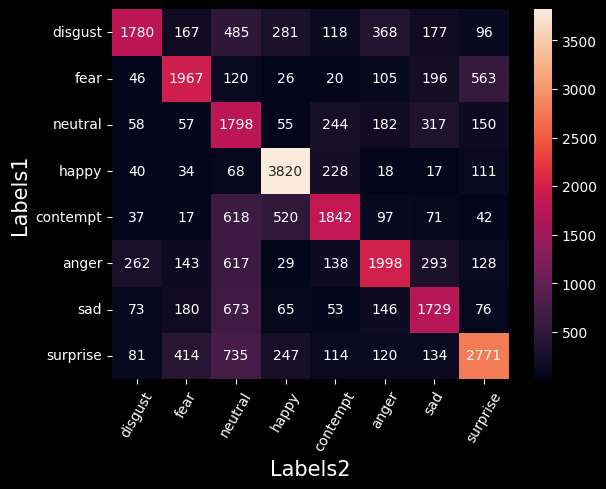

In [13]:
def show_Corr_Matrix():
    matrix = np.asarray(tf.math.confusion_matrix(Data['labels1'],Data['labels2']))
    sn.heatmap(matrix,annot=True,fmt = ".0f",
               xticklabels=classes ,yticklabels= classes,
              )
    plt.ylabel("Labels1",fontsize = 15)
    plt.xlabel("Labels2",fontsize = 15)
    plt.xticks(rotation=60)
    plt.show()

show_Corr_Matrix()

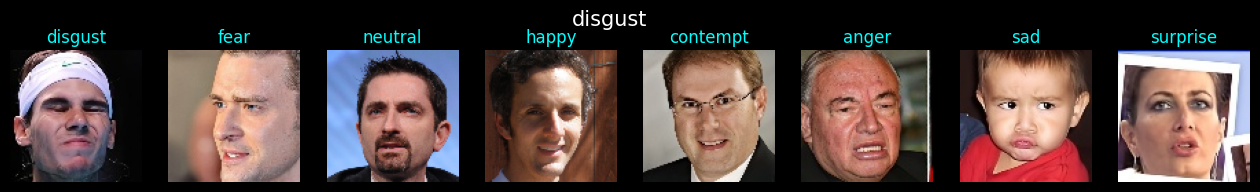

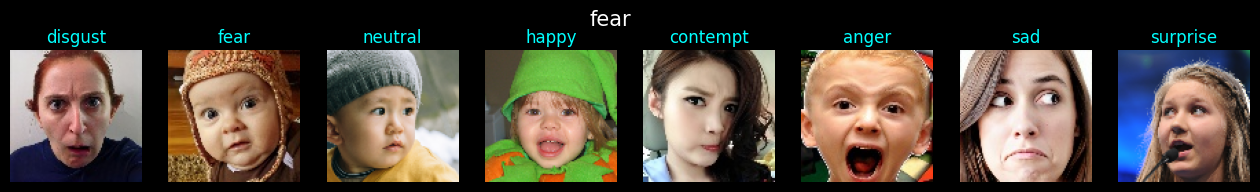

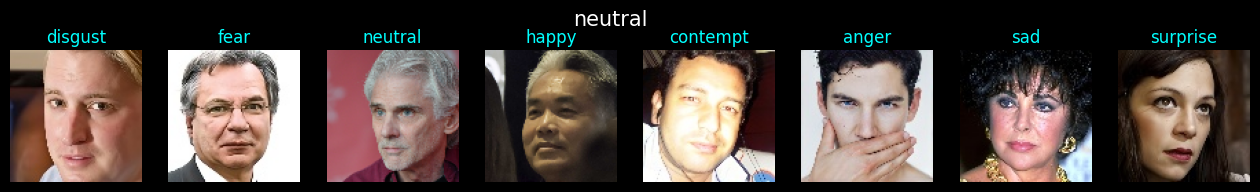

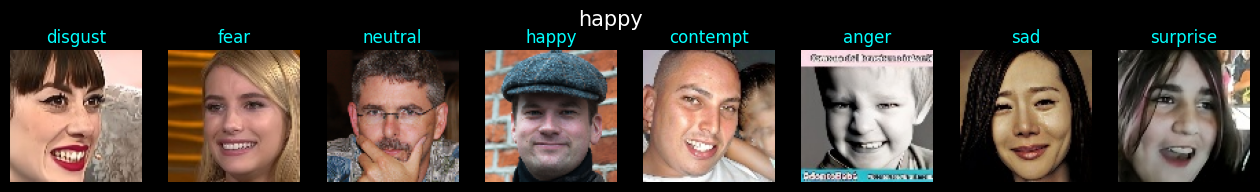

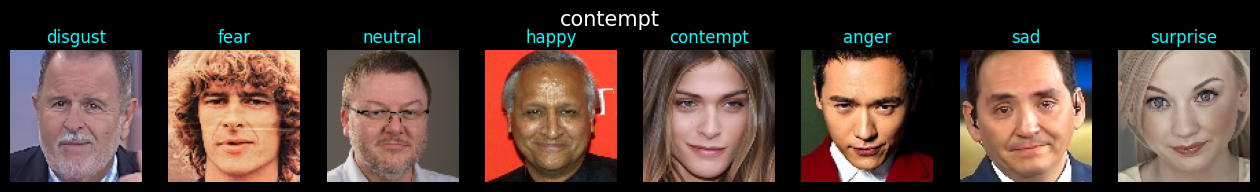

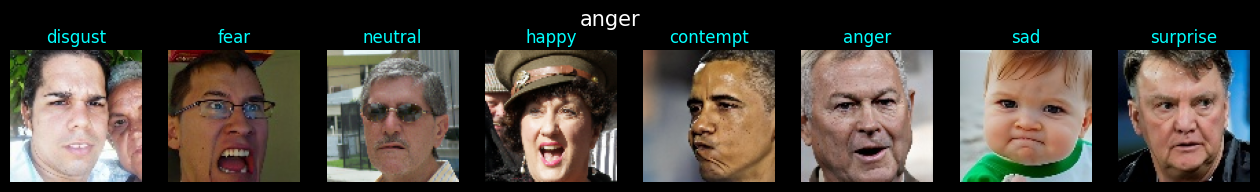

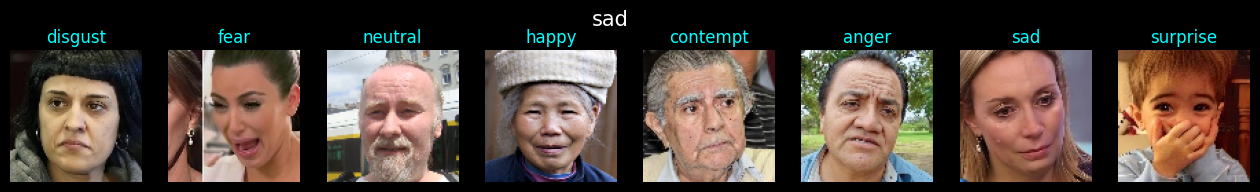

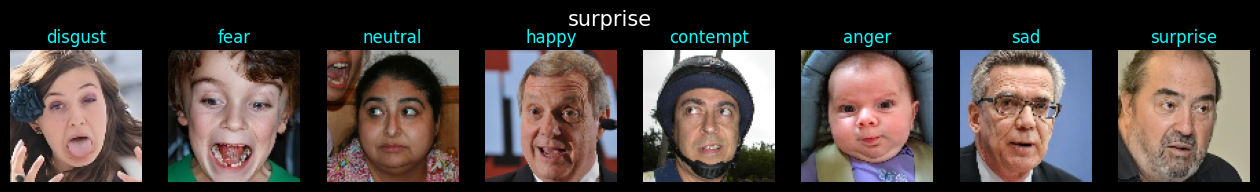

In [14]:
classes = configuration['classes']
num = len(classes)
def Show_images_matrix(size = 2):
    try:
        for i,class_ in enumerate(classes):
            images = []
            for j in range(num):
                sample = Data[(Data.labels1 == i) & (Data.labels2 == j)].sample()
                image = Image.open(sample.values[0][0])
                images.append(image)
            display_images(images ,Labels = classes ,size = size ,grid = (1,num),title = class_)
    except Exception as e:
        print(e)
Show_images_matrix()

In [15]:
Data = Data[ Data['labels1'] == Data['labels2'] ]
Data['labels'] = Data.iloc[:,1]
Data = Data.iloc[:,[0,3]]

Counts = pd.DataFrame({
                        "Class": configuration['classes'],
                        "label_count" :[Counter(Data['labels'])[i] for i in range(configuration['n_class'])],
                      })
Total = pd.DataFrame({
                        "Class": ["Total",],
                        "label_count" :[Counts['label_count'].sum(),],
                      },)
Counts = pd.concat([Counts,Total],ignore_index=True)
Counts.sort_index()

Class  label_count
0   disgust         1780
1      fear         1967
2   neutral         1798
3     happy         3820
4  contempt         1842
5     anger         1998
6       sad         1729
7  surprise         2771
8     Total        17705

## Data Visualisation

In [16]:
data_path = 'datasets/HumanFaces/Images/'
images_path = os.listdir(data_path)
images_path[:5]

['disgust_image0042092.jpg',
 'anger_image0020520.jpg',
 'neutral_ffhq_1991.png',
 'disgust_image0032562.jpg',
 'anger_image0026112.jpg']

In [17]:
classes = configuration['classes']
def Show_images(num = 5 ,size=3):
    try:
        for i,class_ in enumerate(classes):
            images_path = Data[Data.labels == i].sample(num).paths.values
            images = []
            for img_path in images_path:
                image = Image.open(img_path)
                images.append(image)
            display_images(images ,size = size ,grid = (1,num),title=class_)
    except Exception as e:
        print(e)

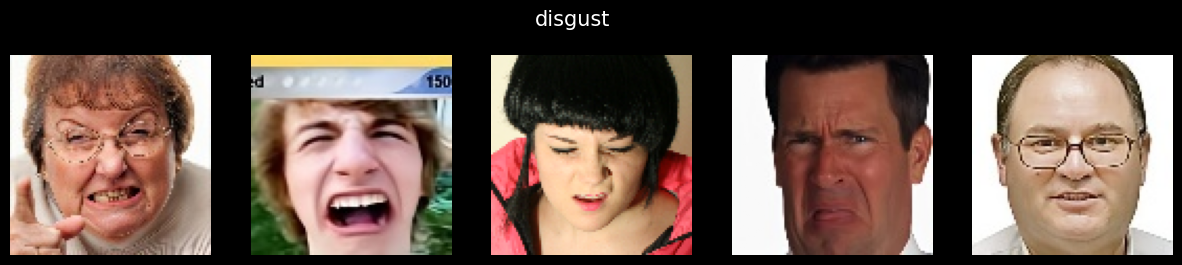

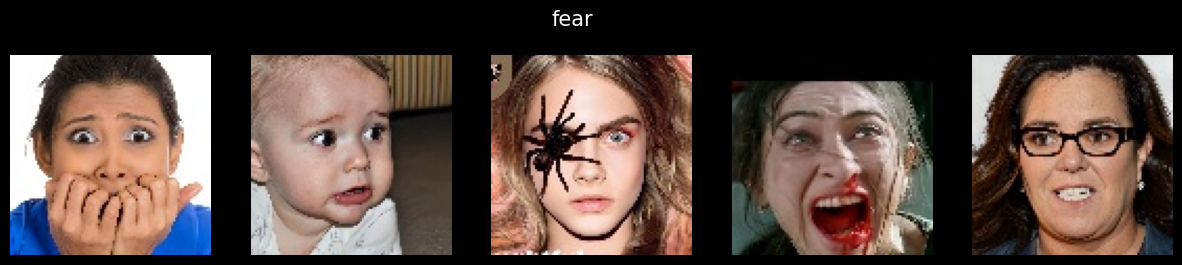

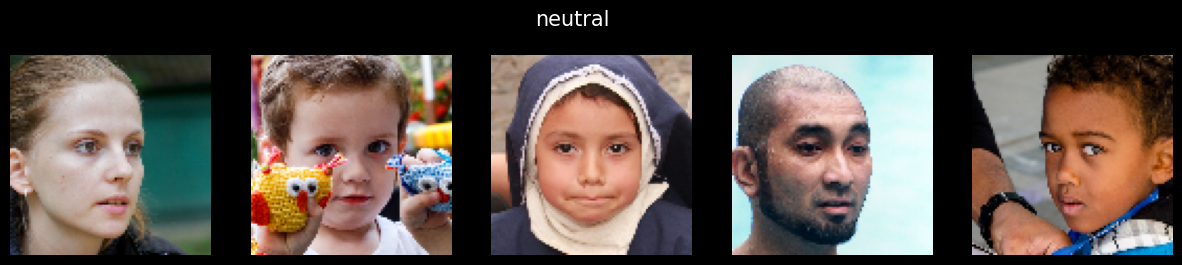

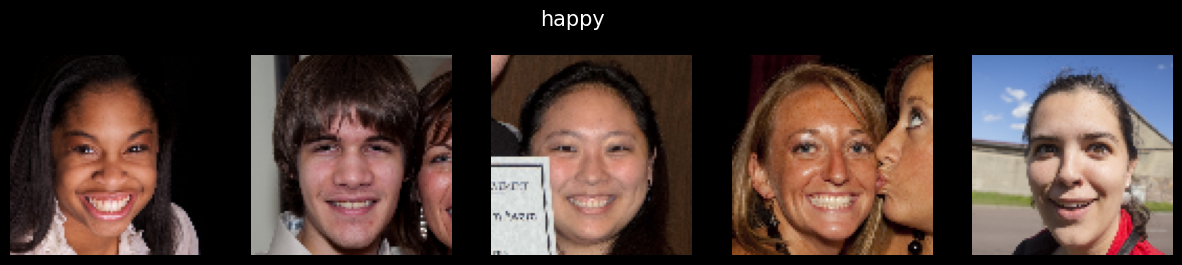

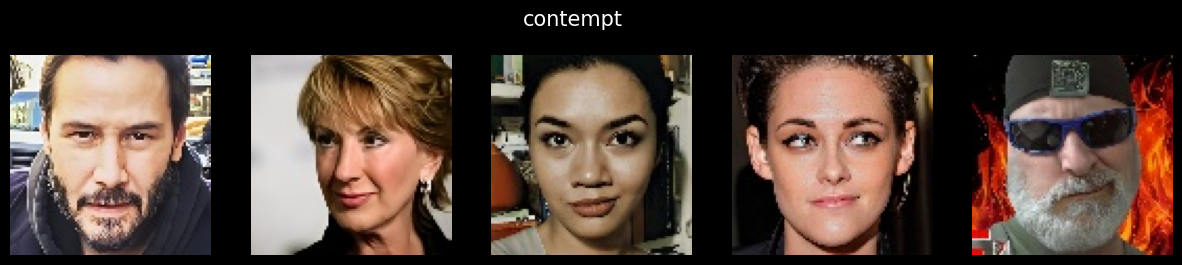

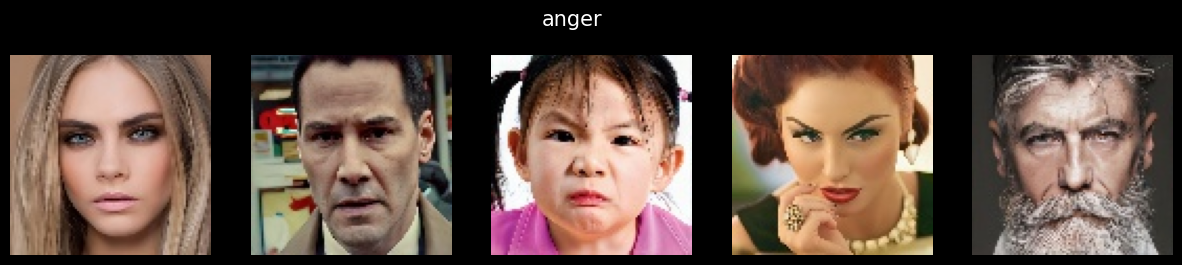

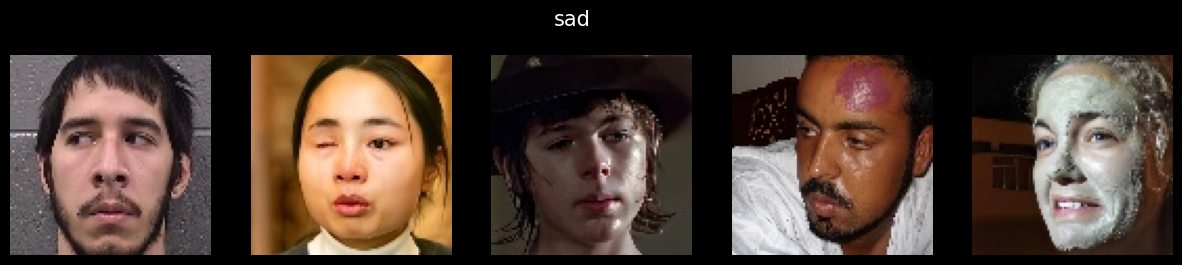

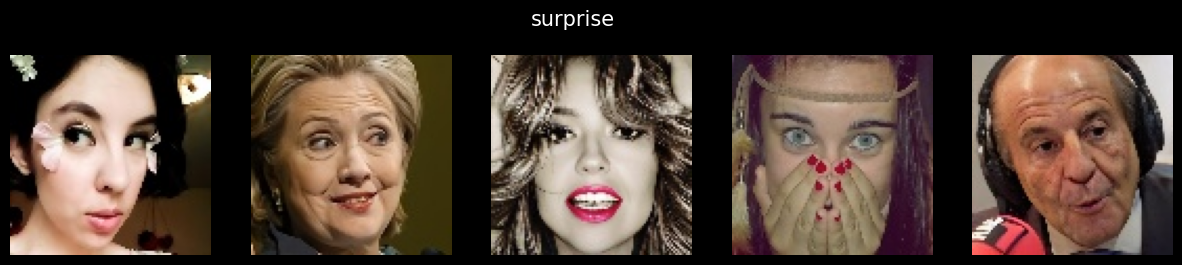

In [18]:
Show_images()

In [19]:
def get_size():
    Set = set()
    try:
        for im_path in tqdm(Data.paths):
            if('.' in im_path):
                image = Image.open(im_path)            
                Set.add(np.shape(image))            
    except Exception as e:
        print(e)
        
    return np.array(list(Set))

In [20]:
sizes = get_size()
sizes = pd.DataFrame(sizes)
sizes.describe()

100%|██████████| 17705/17705 [00:06<00:00, 2695.19it/s]


0     1    2
count   1.0   1.0  1.0
mean   96.0  96.0  3.0
std     NaN   NaN  NaN
min    96.0  96.0  3.0
25%    96.0  96.0  3.0
50%    96.0  96.0  3.0
75%    96.0  96.0  3.0
max    96.0  96.0  3.0

In [21]:
del sizes

## Load Data

In [22]:
# get X and Y
# shape = configuration['shape']
def get_X_Y():
    X = []
    Y = []
    try:
        for im_path,label in tqdm(Data.values):
            if('.' in im_path):
                image = Image.open(im_path)  
#                 image = image.resize(shape[:2])
                X.append(np.array(image,dtype ='float64'))
                Y.append(label)
    except Exception as e:
        print(e)
    return np.array(X),np.array(Y)
X,Y = get_X_Y()

100%|██████████| 17705/17705 [00:09<00:00, 1869.89it/s]


In [23]:
from sklearn.model_selection import train_test_split 
X_train ,X_test ,Y_train ,Y_test = train_test_split( X,Y,
                                                    test_size = 0.2,
                                                    random_state = rs+1,
                                                    stratify = Y )

X_train ,X_val ,Y_train ,Y_val = train_test_split( X_train,Y_train,
                                                    test_size = 0.1,
                                                    random_state = rs+1,
                                                    stratify = Y_train )

print(X_train.shape,X_test.shape,X_val.shape,Y_train.shape,Y_test.shape,Y_val.shape)
print(Counter(Y_train))
print(Counter(Y_test))
print(Counter(Y_val))

(12747, 96, 96, 3) (3541, 96, 96, 3) (1417, 96, 96, 3) (12747,) (3541,) (1417,)
Counter({3: 2750, 7: 1995, 5: 1438, 1: 1416, 4: 1327, 2: 1294, 0: 1282, 6: 1245})
Counter({3: 764, 7: 554, 5: 400, 1: 393, 4: 368, 2: 360, 0: 356, 6: 346})
Counter({3: 306, 7: 222, 5: 160, 1: 158, 4: 147, 2: 144, 0: 142, 6: 138})


In [24]:
del X,Y

In [25]:
from tensorflow.data import Dataset
train_Data = Dataset.from_tensor_slices((X_train,Y_train))
val_Data = Dataset.from_tensor_slices((X_val,Y_val))

train_Data = (train_Data
              .batch(configuration['batch_size'],drop_remainder = True)
              .prefetch(tf.data.AUTOTUNE)
             )
val_Data = (val_Data
            .batch(configuration['batch_size'],drop_remainder = True)
            .prefetch(tf.data.AUTOTUNE)
           )
train_Data,val_Data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(32, 96, 96, 3), dtype=tf.float64, name=None), TensorSpec(shape=(32,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(32, 96, 96, 3), dtype=tf.float64, name=None), TensorSpec(shape=(32,), dtype=tf.int64, name=None))>)

In [26]:
del X_train,Y_train,X_val,Y_val

## Building Model

In [27]:
from tensorflow.data import Dataset
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,Flatten,Conv2D,MaxPool2D,Activation,Layer
from tensorflow.keras.layers import BatchNormalization,GlobalAveragePooling2D,Dropout
from tensorflow.keras.layers import RandomFlip , RandomContrast ,RandomZoom,RandomRotation,Resizing
from tensorflow.keras.metrics import Accuracy,SparseTopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy,SparseCategoricalCrossentropy
from tensorflow.keras.applications import ResNet50,DenseNet121,EfficientNetV2B0
from tensorflow.keras.applications import resnet50,efficientnet,densenet
from tensorflow.keras import regularizers
from tensorflow.keras.layers import concatenate,add

In [28]:
import tensorflow as tf
@keras.saving.register_keras_serializable(name ="RandomAugment")
# @tf.function
class RandomAugment(tf.keras.layers.Layer):
    def __init__(self, min_size, contrast_delta=0.7, hue_delta=0.3):
        # Correctly calling the parent class's __init__ method
        super().__init__()
        self.min_size = min_size
        self.contrast_delta = contrast_delta
        self.hue_delta = hue_delta
        
    def call(self, inputs,training = True):
        if(training):
            # Get the shape of the input
            shape = tf.shape(inputs)
            batch_size = shape[0]

            # Randomly sample heights and widths for cropping
            heights = tf.random.uniform([batch_size], self.min_size, shape[1], dtype=tf.int32)
            widths = tf.random.uniform([batch_size], self.min_size, shape[2], dtype=tf.int32)

            # Randomly generate contrast and hue changes for each image
            hue_deltas = tf.random.uniform([batch_size], -self.hue_delta, self.hue_delta)
            contrast_factors = tf.random.uniform([batch_size], 1 - self.contrast_delta, 1 + self.contrast_delta)

            # Use TensorFlow's built-in function to process each image in the batch
            def augment_image(image, height, width, hue_delta, contrast_factor):
                image = tf.image.random_crop(image, size=[height, width, shape[-1]])
                image = tf.image.resize(image, size=shape[1:3])  # Resize back to original size
                image = tf.image.adjust_contrast(image, contrast_factor)
                image = tf.image.adjust_hue(image, hue_delta)
                return image

            # Apply augmentations across the batch using `tf.map_fn`
            crops = tf.map_fn(
                lambda x: augment_image(x[0], x[1], x[2], x[3], x[4]),
                elems=(inputs, heights, widths, hue_deltas, contrast_factors),
                dtype=tf.float32
            )

            return crops
        else:
            return inputs
    
    def compute_output_shape(self, input_shape):
        # Output shape after random crop and resize
        return input_shape

    def get_config(self):
        config = super(RandomAugment, self).get_config()
        config.update({
            'min_size': self.min_size,
            'contrast_delta': self.contrast_delta,
            'hue_delta': self.hue_delta
        })
        return config

In [29]:
def get_Augment(x_shape):
    fn_input = Input(x_shape)
    x = RandomRotation(fill_mode='constant' ,interpolation='bilinear',fill_value = 0,factor = 60/360,)(fn_input)
    x = RandomAugment(50)(x) # Keep it before some other layer as giving error if kept at last
    x = RandomFlip('horizontal')(x)
    aug_model = Model(fn_input,x)
    aug_model.name = "aug_model"
    return aug_model

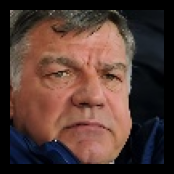

(10, 96, 96, 3)


In [30]:
image = Image.open(Data['paths'].iloc[12])

shape = configuration['shape']
image = image.resize(shape[:2])

display_images([image],size = 2)

images = np.array( [np.array(image),]*10 ,dtype = 'float64')
print(images.shape)

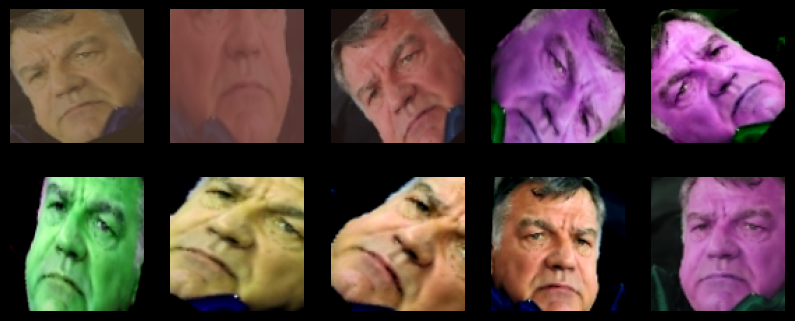

In [31]:
aug_model = get_Augment(shape)
out_images = aug_model(images)

display_images(out_images,grid=(2,5),size = 2)

In [32]:
def Build_Model():
    shape = configuration['shape']
    activ = configuration['activation']
    n_class = configuration['n_class']
    
    aug_model = get_Augment(shape)
    fn_input = Input(shape)
    x = aug_model(fn_input)
    
    x = BatchNormalization()(x)
    
    x = Conv2D(filters = 32
               ,kernel_size = 3
               ,strides = 1
               ,padding = 'same'
               ,use_bias= False
               ,activation = None
              )(x)
    x = BatchNormalization()(x)
    x = Activation(activ)(x)
    x = MaxPool2D(pool_size=2,strides = 2)(x)


    x = Conv2D(filters = 32
               ,kernel_size = 3
               ,strides = 1
               ,padding = 'same'
               ,activation = None
               ,use_bias= False
              )(x)
    x = BatchNormalization()(x)
    x = Activation(activ)(x)
    x = MaxPool2D(pool_size=2,strides = 2)(x)


    x = Conv2D(filters = 64               
               ,kernel_size = 3
               ,strides = 1
               ,padding = 'same'
               ,use_bias= False
               ,activation = None
               ,dilation_rate = 2 
              )(x)
    x = BatchNormalization()(x)
    x = Activation(activ)(x)
    x = MaxPool2D(pool_size=2,strides = 2)(x)

    
    x = Conv2D(filters = 64
               ,kernel_size = 3
               ,strides = 1
               ,padding = 'same'
               ,activation = None
               ,use_bias = False
               ,dilation_rate = 2 
              )(x)
    x = BatchNormalization()(x)
    x = Activation(activ)(x)
    x = MaxPool2D(pool_size=2,strides = 2)(x)

    x = Conv2D(filters = 128
               ,kernel_size = 3
               ,strides = 1
               ,padding = 'same'
               ,activation = activ
               ,use_bias = False
               ,dilation_rate = 3
              )(x)
    x = BatchNormalization()(x)
    x = Activation(activ)(x)
    
    x = GlobalAveragePooling2D()(x)

    x = Dense(128,activation= activ,kernel_regularizer = reg)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(32,activation= activ,kernel_regularizer = reg)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    if(n_class > 2):
        x = Dense(n_class , activation = 'softmax')(x)
    else:
        x = Dense(1 , activation = 'sigmoid')(x)
            
    my_model = Model(fn_input,x)
    my_model.name = 'My_Model'
    return my_model

In [33]:
@keras.saving.register_keras_serializable(package = 'Custom' ,name = 'PreprocessingLayer')
class PreprocessingLayer(Layer):
    def __init__(self, trainable = False,dtype = 'float64'):
        super(PreprocessingLayer, self).__init__(dtype=dtype,trainable= trainable,name = 'Preprocess_Layer')
    def call(self, inputs):
#         return efficientnet.preprocess_input(inputs)
        return densenet.preprocess_input(inputs)

def Build_Model2(base_model):
    reg = regularizers.l2(0.0005)
    shape = configuration['shape']
    activ = configuration['activation']
    n_class = configuration['n_class']
    
    fn_input = Input(shape)
    x = get_Augment(shape)(fn_input)

    x = Resizing(224,224)(x)
    x = PreprocessingLayer()(x)
    
    x = base_model(x)
    x = BatchNormalization()(x)
    
    x1 = Dense(128,activation = 'relu',kernel_regularizer = reg)(x)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.5)(x1)
    
    x1 = Dense(32,activation= 'relu',kernel_regularizer = reg)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.5)(x1)
    
    x2 = Dense(128,activation = 'gelu',kernel_regularizer = reg)(x)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.5)(x2)
    
    x2 = Dense(32,activation= 'gelu',kernel_regularizer = reg)(x2)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.5)(x2)

    x3 = Dense(128,activation = tf.nn.swish,kernel_regularizer = reg)(x)
    x3 = BatchNormalization()(x3)
    x3 = Dropout(0.5)(x3)
    
    x3 = Dense(32,activation= tf.nn.swish,kernel_regularizer = reg)(x3)
    x3 = BatchNormalization()(x3)
    x3 = Dropout(0.5)(x3)
    
    x = concatenate([x1,x2,x3])
    x = Dense(32,activation= activ,kernel_regularizer = reg)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    if(n_class > 2):
        x = Dense(n_class , activation = 'softmax')(x)
    else:
        x = Dense(1 , activation = 'sigmoid')(x)
            
    my_model = Model(fn_input,x)
    my_model.name = 'My_Model'+'_' + base_model.name.upper();    
    
    return my_model

In [34]:
shape = configuration['shape']
reg = regularizers.l2(0.0005)
d_base_model = DenseNet121(input_shape=(224,224,3),
                   weights='imagenet',
                   include_top = False,
                   pooling='avg',
                               )

d_base_model.trainable = False

# Add L2 regularization to each layer in the base model
for layer in d_base_model.layers:
    if isinstance(layer, keras.layers.Conv2D):
        layer.kernel_regularizer = reg

d_base_model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

In [35]:
my_model = Build_Model2(d_base_model)
my_model.summary()

Model: "My_Model_DENSENET121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aug_model           │ (None, 96, 96, 3) │          0 │ input_layer_2[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 224, 224,  │          0 │ aug_model[0][0]   │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Preprocess_Layer    │ (None, 224, 224,  │          0 │ resizing[0][0]    │
│ (PreprocessingLaye… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet121         │ (None, 1024)      │  7,037,504 │ Preprocess_Layer… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024)      │      4,096 │ densenet121[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    131,200 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    131,200 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │    131,200 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      4,128 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      4,128 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      4,128 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_3[0][0]   

 Total params: 7,453,000 (28.43 MB)

 Trainable params: 412,424 (1.57 MB)

 Non-trainable params: 7,040,576 (26.86 MB)

In [36]:
# models.clone_model(my_model)

## Training Model 

In [37]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,CSVLogger

In [39]:
plateau_callback = ReduceLROnPlateau(
                        monitor= 'val_loss'
                        ,min_delta = 0
                        ,factor = 0.6
                        ,cooldown = 1
                        ,verbose = 1
                        ,min_lr = 10^(-5)
                        ,patience = 6
)

try:
    os.makedirs('Models/')
except:
    pass
    
model_path = 'Models/'+ 'my_model_densenet' +'.weights.h5'
checkpoint_callback = ModelCheckpoint(
                    filepath = model_path
                    ,monitor = 'val_loss'
                    ,verbose = 1
#                     ,initial_value_threshold = 1.0
                    ,save_best_only = True
                    ,save_weights_only = True,
)
 
try:
    os.makedirs('Models_Logs/')
except:
    pass
    
model_log_path = "Models_Logs/" + "my_model_densenet" + '_log.csv'
log_callback = CSVLogger(
        filename = model_log_path,
        append = True,
)

In [72]:
for layer in my_model.layers:
    # Check if the layer belongs to ResNet50 (e.g., using layer name or type)
    if 'densenet' in layer.name:
        layer.trainable = True
lr = 0.0005
# lr = 0.005
# lr = configuration['lr']

my_model.compile(
    optimizer = Adam(lr),
    loss=SparseCategoricalCrossentropy(),
    metrics = ['accuracy',SparseTopKCategoricalAccuracy(k = 2,name="top_k_accuracy")]
)

In [73]:
# n_epoch = configuration['n_epoch']
n_epoch = 20
history = my_model.fit(
    train_Data,
    validation_data = val_Data,
    epochs = n_epoch,
    verbose = 1,
    callbacks= [checkpoint_callback
                ,plateau_callback
                ,log_callback
               ]
)

Epoch 1/20
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.7677 - loss: 0.7478 - top_k_accuracy: 0.8950
Epoch 1: val_loss did not improve from 0.69014
398/398 ━━━━━━━━━━━━━━━━━━━━ 326s 649ms/step - accuracy: 0.7677 - loss: 0.7478 - top_k_accuracy: 0.8950 - val_accuracy: 0.7528 - val_loss: 0.7065 - val_top_k_accuracy: 0.9190 - learning_rate: 5.0000e-04
Epoch 2/20
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.7599 - loss: 0.7486 - top_k_accuracy: 0.8977
Epoch 2: val_loss improved from 0.69014 to 0.61940, saving model to Models/my_model_densenet.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 256s 643ms/step - accuracy: 0.7599 - loss: 0.7486 - top_k_accuracy: 0.8977 - val_accuracy: 0.7869 - val_loss: 0.6194 - val_top_k_accuracy: 0.9240 - learning_rate: 5.0000e-04
Epoch 3/20
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.7714 - loss: 0.7205 - top_k_accuracy: 0.9020
Epoch 3: val_loss did not improve from 0.61940
398/398 ━━━━━━━━━━━━━━━━━━━━ 254s 639ms/step - accuracy: 

In [74]:
my_model.load_weights(model_path)
History = pd.read_csv(model_log_path)[['loss'
                                       ,'val_loss'
                                       ,'accuracy'
                                       ,'val_accuracy'
                                       ,'top_k_accuracy'
                                       ,'val_top_k_accuracy'
                                       ,'learning_rate'
                                      ]]
History.iloc[-5:]

loss  val_loss  accuracy  val_accuracy  top_k_accuracy  \
52  0.520981  0.604880  0.841080      0.802557        0.939227   
53  0.498239  0.604877  0.856627      0.803267        0.942447   
54  0.490040  0.637353  0.854742      0.806818        0.944802   
55  0.476421  0.637474  0.856470      0.799006        0.947550   
56  0.467439  0.660523  0.861966      0.785511        0.948650   

    val_top_k_accuracy  learning_rate  
52            0.932528        0.00018  
53            0.930398        0.00018  
54            0.919744        0.00018  
55            0.926847        0.00018  
56            0.926847        0.00018

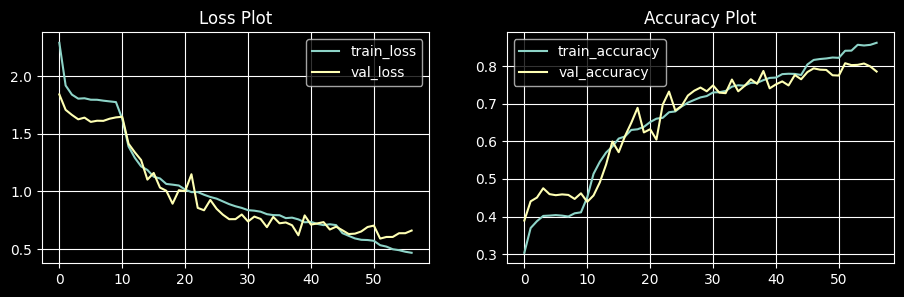

In [75]:
plt.figure(figsize=(11,3))

plt.subplot(1,2,1)
plt.plot(History['loss'],label = 'train_loss')
plt.plot(History['val_loss'],label = 'val_loss')
plt.grid()
plt.legend()
plt.title("Loss Plot")

plt.subplot(1,2,2)
plt.plot(History['accuracy'],label = 'train_accuracy')
plt.plot(History['val_accuracy'],label = "val_accuracy")
plt.grid()
plt.legend()
plt.title("Accuracy Plot")
plt.show()

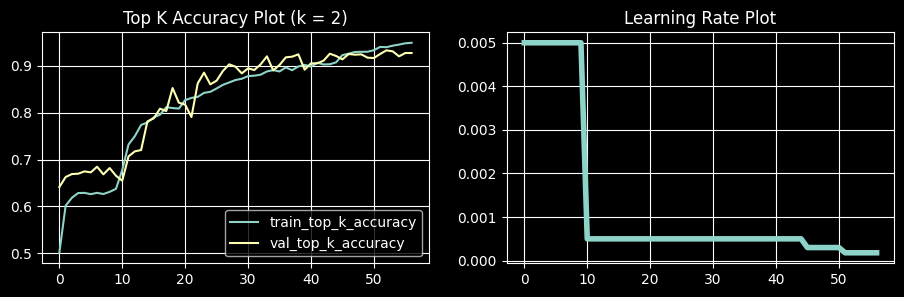

In [76]:
plt.figure(figsize=(11,3))
plt.subplot(1,2,1)
plt.plot(History['top_k_accuracy'],label = 'train_top_k_accuracy')
plt.plot(History['val_top_k_accuracy'],label = "val_top_k_accuracy")
plt.grid()
plt.legend()
plt.title("Top K Accuracy Plot (k = 2)")

plt.subplot(1,2,2)
plt.plot(History['learning_rate'],linewidth = 4)
plt.grid()
plt.title("Learning Rate Plot")
plt.show()

## Evaluating Model

In [80]:
Y_pred = my_model.predict(X_test)
Y_pred = Y_pred.argmax(axis = 1)

111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step


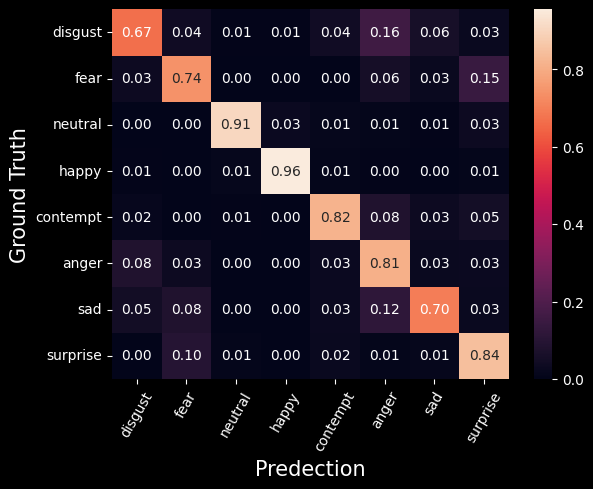

disgust        fear     neutral       happy    contempt  \
precision    0.759615    0.723881    0.942197    0.982503    0.831025   
recall       0.665730    0.740458    0.905556    0.955497    0.815217   
f1-score     0.709581    0.732075    0.923513    0.968812    0.823045   
support    356.000000  393.000000  360.000000  764.000000  368.000000   

                anger         sad    surprise  accuracy    macro avg  \
precision    0.670124    0.795380    0.790541  0.823496     0.811908   
recall       0.807500    0.696532    0.844765  0.823496     0.803907   
f1-score     0.732426    0.742681    0.816754  0.823496     0.806111   
support    400.000000  346.000000  554.000000  0.823496  3541.000000   

           weighted avg  
precision      0.827947  
recall         0.823496  
f1-score       0.824133  
support     3541.000000

In [81]:
def show_Confusion_Matrix(Y_test_,Y_pred_):
    matrix = np.matrix(tf.math.confusion_matrix(Y_test_,Y_pred_),dtype = 'float64')
    matrix/=matrix.sum(axis = 1)
    sn.heatmap(matrix,annot=True,fmt = ".2f",
               xticklabels=classes ,yticklabels= classes,
              )
    plt.ylabel("Ground Truth",fontsize = 15)
    plt.xlabel("Predection",fontsize = 15)
    plt.xticks(rotation=60)
    plt.show()

show_Confusion_Matrix(Y_test,Y_pred)

from sklearn.metrics import classification_report
report = classification_report(Y_test,Y_pred , output_dict= True,target_names= classes)
pd.DataFrame(report)

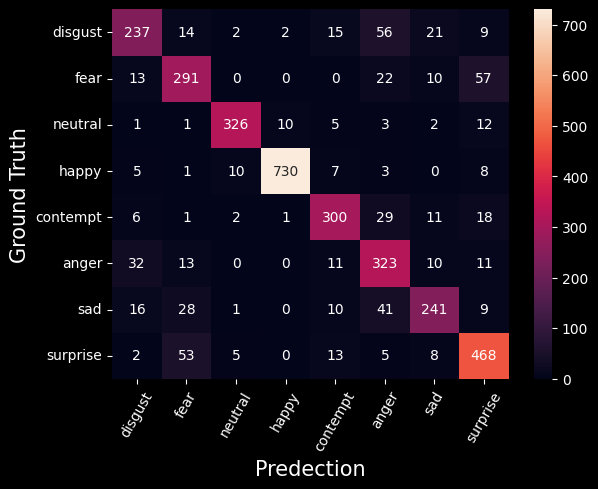

disgust        fear     neutral       happy    contempt  \
precision    0.759615    0.723881    0.942197    0.982503    0.831025   
recall       0.665730    0.740458    0.905556    0.955497    0.815217   
f1-score     0.709581    0.732075    0.923513    0.968812    0.823045   
support    356.000000  393.000000  360.000000  764.000000  368.000000   

                anger         sad    surprise  accuracy    macro avg  \
precision    0.670124    0.795380    0.790541  0.823496     0.811908   
recall       0.807500    0.696532    0.844765  0.823496     0.803907   
f1-score     0.732426    0.742681    0.816754  0.823496     0.806111   
support    400.000000  346.000000  554.000000  0.823496  3541.000000   

           weighted avg  
precision      0.827947  
recall         0.823496  
f1-score       0.824133  
support     3541.000000

In [82]:
def show_Confusion_Matrix(Y_test_,Y_pred_):
    matrix = np.asarray(tf.math.confusion_matrix(Y_test_,Y_pred_))
    sn.heatmap(matrix,annot=True,fmt = ".0f",
               xticklabels=classes ,yticklabels= classes,
              )
    plt.ylabel("Ground Truth",fontsize = 15)
    plt.xlabel("Predection",fontsize = 15)
    plt.xticks(rotation=60)
    plt.show()

show_Confusion_Matrix(Y_test,Y_pred)

from sklearn.metrics import classification_report
report = classification_report(Y_test,Y_pred , output_dict= True,target_names= classes)
pd.DataFrame(report)

In [47]:
# os.remove(model_log_path)
# os.remove(model_path)

In [ ]:
my_model_2 = Build_Model2(vf_base_model)
my_model_2.load_weights(model_path)